# Movie Recommendations

**Recommendation systems** are used to filter among a catalog of possibilities, which ones should be presented to the user. Those systems can be used to enhance the user experience by making the content available to user relavant. In this project, we're going to explore a <a href="https://grouplens.org/datasets/movielens/25m/">movie dataset</a>, and present some of the key types of recommendations systems.

## 1. Importing and inspecting data

### 1.1 Inspection

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-pastel')

We start by importing and checking our data.

In [2]:
# Data probably won't be on the repo due to size of the files. Link for download above.
movies = pd.read_parquet("../data/movies.parquet")
ratings = pd.read_parquet("../data/ratings.parquet")

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [5]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [6]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [7]:
movies.describe()

,movieId
count,62423.000000
mean,122220.387646
std,63264.744844
min,1.000000
25%,82146.500000
50%,138022.000000
75%,173222.000000
max,209171.000000


In [8]:
ratings.describe()

,userId,movieId,rating,timestamp
count,2.500010e+07,2.500010e+07,2.500010e+07,2.500010e+07
mean,8.118928e+04,2.138798e+04,3.533854e+00,1.215601e+09
std,4.679172e+04,3.919886e+04,1.060744e+00,2.268758e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,4.051000e+04,1.196000e+03,3.000000e+00,1.011747e+09
50%,8.091400e+04,2.947000e+03,3.500000e+00,1.198868e+09
75%,1.215570e+05,8.623000e+03,4.000000e+00,1.447205e+09
max,1.625410e+05,2.091710e+05,5.000000e+00,1.574328e+09


In [9]:
ratings['rating'].value_counts()

4.0    6639798
3.0    4896928
5.0    3612474
3.5    3177318
4.5    2200539
2.0    1640868
2.5    1262797
1.0     776815
1.5     399490
0.5     393068
Name: rating, dtype: int64

`dtype` for ratings seems to be a bit too much.

Checking for missing data.

In [10]:
movies.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [11]:
ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Checking duplicates.

In [12]:
movies.duplicated().sum()

0

In [13]:
ratings.duplicated().sum()

0

In [14]:
# There are duplicated titles
movies['title'].duplicated().sum()

98

We don't have any nulls or duplicated data. But be mindful that there are duplicated movies titles.

### 1.2 Preprocessing

In [15]:
# We can set the movieId as index for the table

movies = movies.set_index('movieId')

In [16]:
# We won't be using the timestamp

ratings = ratings.drop('timestamp', axis=1)

In [17]:
ratings['rating'] = ratings['rating'].astype(np.float32)

In [18]:
movies.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [19]:
ratings.head()

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5


In [20]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float32
dtypes: float32(1), int64(2)
memory usage: 476.8 MB


Reduced memory usage significantly without any loss.

## 2. Feature extraction

We are going to extract the year from the title of the movie and create genres columns.

In [21]:
# Extracting year from title with regex
movies_year = movies['title'].str.extract(r'\((\d{4})\)')
movies_year.columns = ['year']
movies_year

,year
movieId,
1,1995
2,1995
3,1995
4,1995
5,1995
...,...
209157,2018
209159,2001
209163,2018


In [22]:
# Creating genres columns
movies_genres = movies['genres'].str.get_dummies('|')
movies_genres

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209157,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
209159,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
209163,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0


We could convert the timestamp to datetime to get temporal features. But for now, we stick to those features.

## 3. EDA

In [23]:
# Auxiliary functions

def get_id_from_title(title):
    return movies.loc[movies['title'] == title].index.item()

def get_title_from_id(movieId):
    return movies.loc[movieId].title

### What are the most present movie genres?

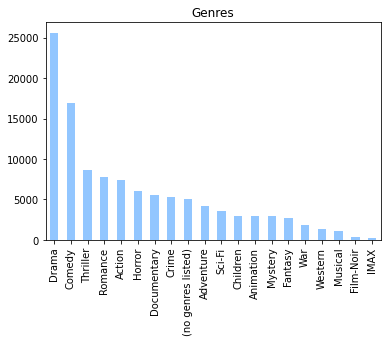

In [24]:
# Most present genres
movies_genres.sum().sort_values(ascending=False).plot(kind='bar')
plt.title('Genres')
plt.show()

### What's the rating distribution for Toy Story (1995)

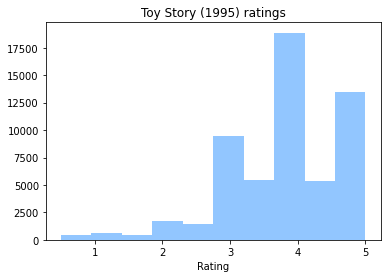

In [25]:
# Choose a movie, and check the rating distribution
plt.hist(ratings.loc[ratings['movieId'] == get_id_from_title('Toy Story (1995)'), 'rating'])
plt.xlabel('Rating')
plt.title('Toy Story (1995) ratings')
plt.show()

### What are the top 3% most rated movies?

In [26]:
# Ratings count - What are the top 3% most rated movies?

ratings_count_percentage = ratings['movieId'].value_counts(normalize=True)

top_3_percent = ratings_count_percentage[ratings_count_percentage.cumsum() <= 0.03]
top_3_percent.rename('rating_percentage', inplace=True)
top_3_percent = pd.merge(left=top_3_percent, right=movies['title'], left_index=True, right_on='movieId')

top_3_percent['rating_percentage_cum'] = top_3_percent['rating_percentage'].cumsum()

top_3_percent

,rating_percentage,title,rating_percentage_cum
movieId,,,
356,0.003260,Forrest Gump (1994),0.003260
318,0.003259,"Shawshank Redemption, The (1994)",0.006519
296,0.003187,Pulp Fiction (1994),0.009706
593,0.002965,"Silence of the Lambs, The (1991)",0.012671
2571,0.002907,"Matrix, The (1999)",0.015578
260,0.002749,Star Wars: Episode IV - A New Hope (1977),0.018326
480,0.002566,Jurassic Park (1993),0.020892
527,0.002416,Schindler's List (1993),0.023309
110,0.002367,Braveheart (1995),0.025676


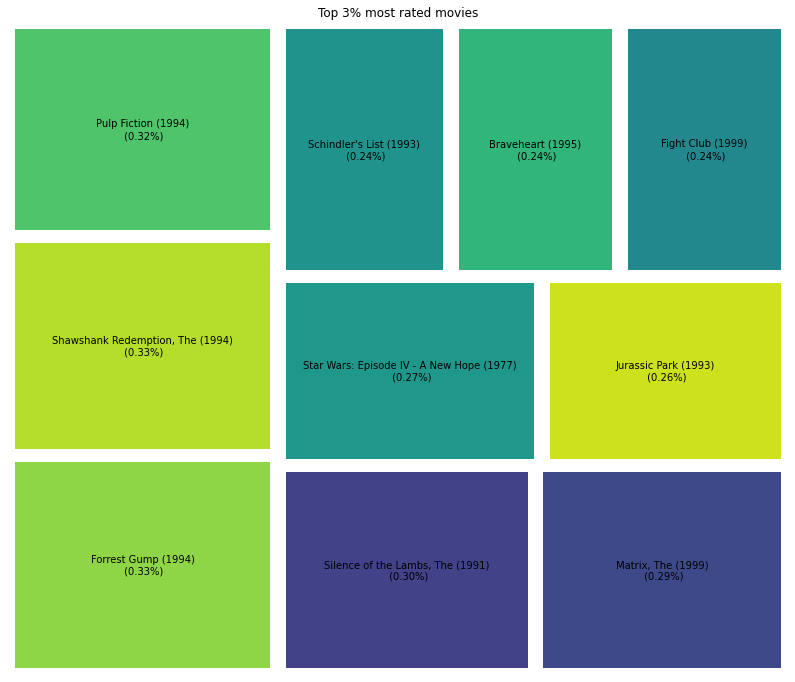

In [27]:
# Visualizing with squarify

#!pip install squarify
import squarify

perc = top_3_percent["rating_percentage"].values * 100
labels = [f"{i[0]}\n ({i[1]:.2f}%)" for i in zip(top_3_percent["title"], perc)]

plt.figure(figsize=(14,12))
squarify.plot(sizes=top_3_percent["rating_percentage"], label=labels,
             pad=1, text_kwargs={'fontsize':10})
plt.axis('off')
plt.title("Top 3% most rated movies")
plt.show()

### Whats the number of movies per year?

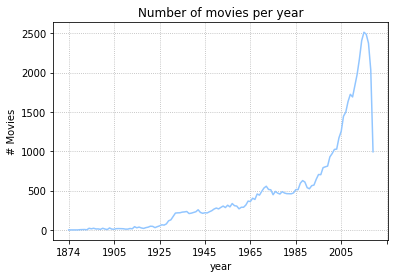

In [28]:
# Movies per year

movies_year.groupby('year').size().plot()
plt.grid(ls=":")
plt.ylabel('# Movies')
plt.title('Number of movies per year')
plt.show()

In [29]:
# Lets inspect User 6 movies

user_6_ratings = ratings.loc[ratings["userId"] == 6, ["movieId","rating"]]
user_6_ratings.merge(movies[["title", "genres"]], left_on="movieId", right_index=True)

,movieId,rating,title,genres
1253,161,2.0,Crimson Tide (1995),Drama|Thriller|War
1254,260,5.0,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
1255,318,5.0,"Shawshank Redemption, The (1994)",Crime|Drama
1256,527,5.0,Schindler's List (1993),Drama|War
1257,593,4.0,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
1258,608,5.0,Fargo (1996),Comedy|Crime|Drama|Thriller
1259,858,5.0,"Godfather, The (1972)",Crime|Drama
1260,902,4.0,Breakfast at Tiffany's (1961),Drama|Romance
1261,912,4.0,Casablanca (1942),Drama|Romance
1262,913,4.0,"Maltese Falcon, The (1941)",Film-Noir|Mystery


**What's the average/median number of reviewed movies per user?**

In [30]:
movies_per_user = ratings.groupby("userId").count()[["rating"]].sort_values(by="rating", ascending=False)

In [31]:
movies_per_user.head(10)

,rating
userId,
72315,32202
80974,9178
137293,8913
33844,7919
20055,7488
109731,6647
92046,6564
49403,6553
30879,5693


In [32]:
movies_per_user.describe()

,rating
count,162541.000000
mean,153.807932
std,268.047590
min,20.000000
25%,36.000000
50%,71.000000
75%,162.000000
max,32202.000000


Our data is very skewed in this sense: the median is more than the double of the mean. Some few users have watched a lot of movies. Just for visualization sake, we're going to remove temporarily those users.

/home/franklin/.local/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


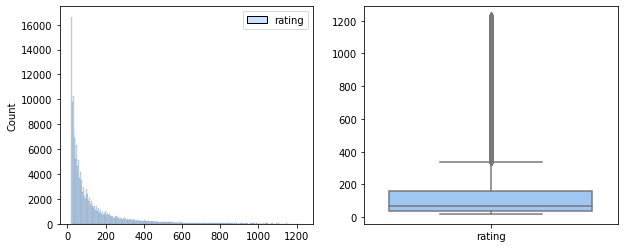

In [33]:
movies_per_user_outliers = movies_per_user[movies_per_user['rating'] < movies_per_user.quantile(0.99).values[0]]

plt.figure(figsize=(10,4))
    
plt.subplot(1,2,1)
sns.histplot(movies_per_user_outliers)

plt.subplot(1,2,2)
sns.boxplot(data=movies_per_user_outliers)

plt.show()

## 4. Search engine

Our first task is to make a **search engine**. When a user type a movie title, a function search the most similar rows in the database. First we clean our titles to get only letters and numbers and convert every instance in a vector using **TF-IDF**. Then, we compare those vectors using **cosine similarity** and return the best items.

In [34]:
# Cleaning titles with regex

import re

def clean(title):
    return re.sub("[^a-zA-Z0-9 ]", "", title)

movies["clean_titles"] = movies["title"].apply(clean)

In [35]:
# TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(ngram_range=(1, 2), stop_words="english", max_df=0.95, min_df=1)

titles_vec = vec.fit_transform(movies["clean_titles"])

In [36]:
from sklearn.metrics.pairwise import cosine_similarity

def search(title):
    title = clean(title)
    query_vec = vec.transform([title])
    similarity = cosine_similarity(query_vec, titles_vec).flatten()
    
    # Selecting top 5 movies
    idx = np.argpartition(similarity, kth=-5)[-5:]

    results = movies.iloc[idx][::-1]
    return results

In [37]:
import ipywidgets as widgets
from IPython.display import display

movie_input = widgets.Text(description="Movie title", value="Toy Story 1995", disabled=False)
movie_output = widgets.Output()

def when_type(data):
    with movie_output:
        movie_output.clear_output()
        title = data["new"]
        if len(title) > 5:
            display(search(title))

movie_input.observe(when_type, names='value')

In [38]:
display(movie_input, movie_output)

Text(value='Toy Story 1995', description='Movie title')

Output()

## 5. Recomendation systems

### 5.1 Non-personalized recomendations

Our first recommenders are **non-personalized** in the sense that they are not based on the individual user information. The information used can be the global watch rate, ratings, seem together movies or content based recommendations. Those systems are useful as product showcase.

#### 5.1.1 High rate/watch movies

A first recommender can be made by ranking the best reviewed movies, but filtering by only movies with a certain number of reviews.

In [39]:
# Movies with more than 500 reviews

review_count = ratings["movieId"].value_counts()
review_count_percentage = review_count / len(ratings["userId"].unique())
pop_movies_100 = review_count_percentage.iloc[:100].index

In [40]:
# Best reviewed movies

pop_movies_ratings = ratings[ratings["movieId"].isin(pop_movies_100)]
movie_rec = pop_movies_ratings[["rating", "movieId"]].groupby("movieId").mean().sort_values(by="rating", 
                                                                           ascending=False)


In [41]:
movie_rec.join(movies[["title"]]).head(10)

,rating,title
movieId,,
318,4.413576,"Shawshank Redemption, The (1994)"
858,4.324336,"Godfather, The (1972)"
50,4.284353,"Usual Suspects, The (1995)"
1221,4.261758,"Godfather: Part II, The (1974)"
527,4.247579,Schindler's List (1993)
2959,4.228311,Fight Club (1999)
1193,4.218662,One Flew Over the Cuckoo's Nest (1975)
296,4.188912,Pulp Fiction (1994)
1213,4.180525,Goodfellas (1990)


It surelly works, but is *pretty generic*.

Another possible approach would be the weighted rating mean by the number of reviews.

#### 5.1.2 Most seem together

If a some users usually watch some movies together, those are probably a good recomendation for another user.
The problem of this approach is the memory usage required to compute and store the permutations between the movies. The code used to generate a database with the permutations is commented due to time requirements, but once precomputed, our task is a simple query.

In [42]:
# from itertools import permutations

# def create_pairs(x):
#     pairs = pd.DataFrame(list(permutations(x.values, 2)), columns=["movie_a", "movie_b"])
#     return pairs

# # Getting a smaller sample from ratings
# n_users = 1000
# selected_users = ratings['userId'].sample(n_users, replace=False).values
# small_ratings = ratings.loc[ratings["userId"].isin(selected_users), ["userId", "movieId"]]

# # Get a smaller movie subset
# small_ratings_count = small_ratings["movieId"].value_counts()
# small_ratings_count = small_ratings_count[small_ratings_count > 250]
# smaller_ratings = small_ratings[small_ratings["movieId"].isin(small_ratings_count.index)]

# # Counting the pairs movies watched by the same user
# pair_counts = smaller_ratings.groupby("userId")["movieId"].apply(create_pairs).reset_index(drop=True)

# # Saving the results
# pair_counts.to_parquet("../data/pair_counts.parquet")

In [43]:
pair_counts = pd.read_parquet("../data/pair_counts.parquet")

In [44]:
# Importing the permutations previously generated

pair_counts = pd.read_parquet("../data/pair_counts.parquet")
pair_counts = pair_counts.groupby(["movie_a", "movie_b"]).size().to_frame(name='size').reset_index()

# Getting movie titles

pair_counts["movie_a_title"] = pair_counts['movie_a'].apply(get_title_from_id)
pair_counts["movie_b_title"] = pair_counts['movie_b'].apply(get_title_from_id)

In [45]:
def seem_together_recommendation(movie_title):
    pairs = pair_counts[pair_counts["movie_a_title"] == movie_title]
    pairs_sorted = pairs.sort_values(by="size", ascending=False)[["movie_b_title"]]
    return pairs_sorted.head(10)

In [46]:
seem_together_recommendation("Toy Story (1995)")

,movie_b_title
32,Forrest Gump (1994)
26,Pulp Fiction (1994)
185,"Matrix, The (1999)"
22,Star Wars: Episode IV - A New Hope (1977)
42,Jurassic Park (1993)
55,"Silence of the Lambs, The (1991)"
28,"Shawshank Redemption, The (1994)"
114,Back to the Future (1985)
91,Raiders of the Lost Ark (Indiana Jones and the...
98,Star Wars: Episode VI - Return of the Jedi (1983)


Now we are going somewhere. Our recomendations to Toy Story are very non-trivial.

#### 5.1.3 Content-based recommendation

Since we have some information on our product, we can use our descriptors (in this case, the genres) to recommend similar products.

In [47]:
from sklearn.metrics import jaccard_score

def jaccard_similarities_recomendation(movieId):
    """
    Get the jaccard similarities between a movie and all others and sort them.
    Then, get the top 10 recommendations.
    """
    pop_movies_1000 = review_count_percentage.iloc[:1000].index
    pop_movies = movies.loc[pop_movies_1000]
    movies_and_genres = pop_movies[["title"]].join(movies_genres).drop("title", axis=1)
    movie_row = movies_and_genres.loc[movieId]
    movies_and_genres['similarities'] = movies_and_genres.apply(lambda x: jaccard_score(movie_row, x), axis=1)
    movies_and_genres = movies_and_genres.sort_values(by='similarities', ascending=False)
    
    return movies_and_genres.head(10).join(movies)[['title', 'genres']]

In [48]:
# Testing for the movieId = 1 (Toy Story 1995)
jaccard_similarities_recomendation(1)

,title,genres
3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy
4016,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy
2294,Antz (1998),Adventure|Animation|Children|Comedy|Fantasy
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4306,Shrek (2001),Adventure|Animation|Children|Comedy|Fantasy|Ro...
673,Space Jam (1996),Adventure|Animation|Children|Comedy|Fantasy|Sc...
134853,Inside Out (2015),Adventure|Animation|Children|Comedy|Drama|Fantasy
78499,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX
108932,The Lego Movie (2014),Action|Adventure|Animation|Children|Comedy|Fan...


It works well when the user is searching for something similar to the watched movie.

### 5.2 Colaborative filtering

Now we are going to use user ratings to create recommendations. Our strategy is to find similar users that liked the movie we just watch. Next we find the movies they liked. With this, we can create a score that takes into account the popularity of the movie - we don't want movies to be recommended just because they are popular.

First we begin by making a prototype and then pack it all in a function and interface.

In [49]:
# Suppose we our user liked the movie with Id 1 (Toy Story)
movie_id = 1

# Users that watched our movie and rated > 4
similar_users = ratings.loc[(ratings["movieId"] == movie_id) & (ratings["rating"] > 4.0), "userId"].unique()

# High rated movies (>4) that our similiar users watched
similar_users_rec = ratings.loc[(ratings["userId"].isin(similar_users)) & (ratings["rating"] > 4.0), "movieId"]

# Counting how many users watched our recomendation. Getting the percentage from similar users
similar_rec_movies_percentage = (similar_users_rec.value_counts() / len(similar_users))

# Restricting ourselves to 10%
similar_rec_movies_percentage = similar_rec_movies_percentage[similar_rec_movies_percentage > 0.1]

similar_rec_movies_percentage.head(5)

1      1.000000
318    0.445607
260    0.403770
356    0.370215
296    0.367295
Name: movieId, dtype: float64

44.56% of the similar users watched movie with ID 318.

In [50]:
# We don't want movies that are there just because they are already popular

all_users = ratings.loc[(ratings["movieId"].isin(similar_rec_movies_percentage.index)&(ratings["rating"]>4.0))]
all_users_recs_percentage = all_users["movieId"].value_counts() / len(all_users["userId"].unique())
all_users_recs_percentage.head(5)

318     0.342220
296     0.284674
2571    0.244033
356     0.235266
593     0.225909
Name: movieId, dtype: float64

But from *all users*, movie 318 is already liked by 34.22%. Thats probably generic. We should create a score:

$$score = \frac{\text{percentage from similar users}}{\text{percentage from all users}} $$

In [51]:
# Creating a score, sorting by it, and showing the top 10 recs

rec_percentages = pd.concat([similar_rec_movies_percentage, all_users_recs_percentage], axis=1)
rec_percentages.columns = ["similar", "all"]
rec_percentages["score"] = rec_percentages["similar"] / rec_percentages["all"]
rec_percentages = rec_percentages.sort_values("score", ascending=False).iloc[:9].merge(movies, left_index=True, right_on="movieId")

rec_percentages[['title']].head(10)

,title
movieId,
1,Toy Story (1995)
3114,Toy Story 2 (1999)
2355,"Bug's Life, A (1998)"
78499,Toy Story 3 (2010)
4886,"Monsters, Inc. (2001)"
588,Aladdin (1992)
6377,Finding Nemo (2003)
595,Beauty and the Beast (1991)
8961,"Incredibles, The (2004)"


In [52]:
# Wrapping in a function

def colab_recommendations(movieId):
    similar_users = ratings.loc[(ratings["movieId"] == movieId) & (ratings["rating"] > 4.0), "userId"].unique()
    similar_users_rec = ratings.loc[(ratings["userId"].isin(similar_users)) & (ratings["rating"] > 4.0), "movieId"]
    similar_rec_movies_percentage = (similar_users_rec.value_counts() / len(similar_users))
    similar_rec_movies_percentage = similar_rec_movies_percentage[similar_rec_movies_percentage > 0.1]
    
    all_users = ratings.loc[(ratings["movieId"].isin(similar_rec_movies_percentage.index)&(ratings["rating"]>4.0))]
    all_users_recs_percentage = all_users["movieId"].value_counts() / len(all_users["userId"].unique())
    rec_percentages = pd.concat([similar_rec_movies_percentage, all_users_recs_percentage], axis=1)
    rec_percentages.columns = ["similar", "all"]
    rec_percentages["score"] = rec_percentages["similar"] / rec_percentages["all"]
    rec_percentages = rec_percentages.sort_values("score", ascending=False).iloc[:9].merge(movies, left_index=True, right_on="movieId")
    
    return rec_percentages[['title']].head(10)

In [53]:
movie_input = widgets.Text(description="Movie title", value="The Godfather", disabled=False)
movie_recommendation = widgets.Output()

def when_type(data):
    with movie_recommendation:
        movie_recommendation.clear_output()
        title = data["new"]
        if len(title) > 5:
            results = search(title)
            movie_id = results.reset_index().iloc[0]["movieId"]
            display(colab_recommendations(movie_id))

movie_input.observe(when_type, names='value')

In [54]:
display(movie_input, movie_recommendation)

Text(value='The Godfather', description='Movie title')

Output()

### 5.3. User based recommendations using KNN

Suppose we want to predict the rating for the movie **Star Wars: Episode VI - Return of the Jedi (1983)** for **User 6**. One possibible way to do that is to construct a *pivot table* with the ratings where our rows are the users and the columns are the movies. Using this dataset, we can find the closests neighbors using KNN and use them to predict.

In [55]:
# Our target user and movie we want to predict

target_user = 6
target_movie_id = get_id_from_title("Star Wars: Episode VI - Return of the Jedi (1983)")

In [56]:
def get_pop_movies(n):
    """Get the n-first top movies in terms of review counting."""
    return review_count_percentage.iloc[:n].index

In [57]:
# Restricting to movies that user 1 watched and pop movies 200
user_movies = ratings.loc[ratings['userId'] == target_user, 'movieId'].unique()
pop_movies_200 = get_pop_movies(n=200)

ratings_pop = ratings.loc[(ratings['movieId'].isin(pop_movies_200)) | (ratings['movieId'].isin(user_movies))]

In [58]:
# User based recommendations
ratings_pivot_user = ratings_pop.pivot(index='userId',columns='movieId',values='rating')

In [59]:
ratings_pivot_user

movieId,1,2,6,10,19,21,32,34,39,47,...,54286,58559,59315,60069,68157,68954,72998,79132,99114,109487
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,NaN,4.5,NaN,NaN,NaN,...,4.0,5.0,4.0,4.0,4.0,NaN,4.0,5.0,4.0,4.0
4,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.5,4.5,NaN,4.0,3.5,4.5,2.5,4.5,4.0,5.0
5,4.0,NaN,NaN,NaN,4.0,NaN,5.0,NaN,2.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162538,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,...,NaN,NaN,3.0,NaN,4.0,4.0,2.0,4.0,4.0,NaN
162539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This table contains all the ratings from all users of our reduced movie list. We can verify that this dataset is very sparse, since every user don't watch all movies and all movies aren't watched by all users.

In [60]:
# Verifying sparsity

sparsity = ratings_pivot_user.count().sum() / ratings_pivot_user.size

print(f"{(1-sparsity)*100:.2f}% are NaN values.")

80.20% are NaN values.


Before we fill the missing values, we must center our distribution around zero. Otherwise, if we only naively filled our NaN with zeros, we would be adding the information that the user really disliked that movie.

In [61]:
# Filling missing values

avg_user_rating = ratings_pivot_user.mean(axis=1)
ratings_pivot_user_centered = ratings_pivot_user.sub(avg_user_rating, axis=0).fillna(0)

And now we can predict.

In [62]:
# KNN

from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=3, metric="cosine")

X_target_user = ratings_pivot_user_centered.loc[[target_user]].drop(target_movie_id, axis=1)

other_users = ratings_pivot_user_centered.drop(target_user, axis=0)

X_other_users = other_users.drop(target_movie_id, axis=1)
y_other_users = other_users[target_movie_id]

knn.fit(X_other_users, y_other_users)

y_target_user = knn.predict(X_target_user)[0] + avg_user_rating.loc[target_user]
print(f"Predict rating for {get_title_from_id(target_movie_id)} is {y_target_user:.2f}")

Predict rating for Star Wars: Episode VI - Return of the Jedi (1983) is 4.15


### 5.4 SVD

Another alternative to predict ratings is to use a factorization techinque on our pivot matrix using **Singular Value Decomposition**. Our strategy is to decompose our matrix as $M = U \Sigma V^T$, and then reconstruct our matrix. In this example we will predict the ratings for the *User 1*.

In [63]:
# Restricting to pop movies

target_user = 1
user_movies = ratings.loc[ratings['userId'] == target_user, 'movieId'].unique()
pop_movies_300 = get_pop_movies(n=300)

ratings_pop = ratings.loc[ratings['movieId'].isin(pop_movies_300)]

In [64]:
# Centering results
ratings_pop_pivot = ratings_pop.pivot(index='userId',
                                      columns='movieId',
                                      values='rating')

rating_pop_user_mean = ratings_pop_pivot.mean(axis=1)
ratings_pop_pivot_sub = ratings_pop_pivot.sub(rating_pop_user_mean, axis=0).fillna(0)
ratings_pop_pivot_sub

movieId,1,2,6,10,11,16,17,19,21,25,...,72998,74458,79132,89745,91529,99114,106782,109487,112852,134130
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,-0.524692,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,-0.093023,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,...,-0.093023,-0.093023,0.906977,-0.093023,-0.093023,-0.093023,0.406977,-0.093023,-0.093023,-0.093023
4,-0.801370,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,...,-1.301370,1.198630,0.698630,-1.301370,0.698630,0.198630,0.000000,1.198630,-0.801370,0.198630
5,-0.020000,0.0,0.0,0.0,0.0,0.0,0.000000,-0.02,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162537,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
162538,-1.558824,0.0,0.0,0.0,0.0,0.0,0.441176,0.00,0.0,0.0,...,-1.558824,-0.558824,0.441176,0.000000,0.000000,0.441176,0.000000,0.000000,0.000000,0.000000
162539,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [65]:
# Factorizing

from scipy.sparse.linalg import svds

U, sigma, Vt = svds(ratings_pop_pivot_sub)
sigma = np.diag(sigma)

In [66]:
# Reconstructing and decentering

ratings_pred_centered = np.dot(np.dot(U, sigma), Vt)
ratings_pred = ratings_pred_centered + rating_pop_user_mean.values.reshape(-1,1)
ratings_pred = pd.DataFrame(ratings_pred, index=ratings_pop_pivot_sub.index,
                            columns=ratings_pop_pivot_sub.columns)

ratings_pred

movieId,1,2,6,10,11,16,17,19,21,25,...,72998,74458,79132,89745,91529,99114,106782,109487,112852,134130
userId,,,,,,,,,,,,,,,,,,,,,
1,4.141890,4.177540,4.239012,4.184720,4.191251,4.246072,4.214329,4.191852,4.232677,4.254259,...,4.191417,4.228252,4.220952,4.191945,4.209325,4.235024,4.229060,4.218975,4.201774,4.208671
2,4.029250,3.834147,4.015259,3.942063,3.987069,3.986691,4.081532,3.531067,3.997849,4.013549,...,4.229323,3.988703,4.046440,4.180520,4.113242,3.983219,3.967737,4.011899,4.100688,4.035825
3,3.819251,3.956052,4.180366,4.036202,4.035936,4.195763,4.049268,4.111446,4.112199,4.173976,...,3.944394,4.179577,4.275976,3.978254,4.104702,4.198115,4.155727,4.180463,4.056156,4.107918
4,3.663580,3.723881,3.828042,3.799540,3.785251,3.828139,3.778987,3.810653,3.791519,3.812614,...,3.740832,3.854570,3.968797,3.758799,3.834657,3.854580,3.822617,3.873699,3.800680,3.824739
5,3.926341,3.883534,4.077372,3.943528,3.977792,4.065616,3.985209,3.783557,4.001572,4.025404,...,4.053164,4.019731,4.034566,4.048512,4.056271,4.039459,4.027823,4.027112,4.034968,4.028275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162537,4.395532,4.340314,4.393872,4.347205,4.384054,4.385165,4.372920,4.254984,4.353098,4.357698,...,4.373419,4.387657,4.415188,4.368399,4.386353,4.387557,4.383310,4.395119,4.374470,4.388621
162538,3.694757,3.567507,3.551502,3.530426,3.622258,3.543107,3.638569,3.364821,3.534506,3.544733,...,3.531164,3.614403,3.697926,3.503985,3.556976,3.584359,3.575617,3.621769,3.537494,3.587767
162539,4.660449,4.619376,4.610565,4.599938,4.620115,4.615138,4.647685,4.591136,4.624131,4.633431,...,4.597264,4.620734,4.611742,4.596846,4.598173,4.616296,4.617804,4.612922,4.604400,4.611433


We can use those predictions to suggest movies. But first, lets compare our predictions to the true ratings we had before.

In [67]:
# Comparing the true rating with the predicted

user_1_ratings = ratings_pop[ratings_pop['userId'] == 1]
user_1_ratings.merge(right=ratings_pred.loc[1], on="movieId", how="left")

,userId,movieId,rating,1
0,1,296,5.0,4.538241
1,1,1653,4.0,4.225166
2,1,2011,2.5,4.184169
3,1,2012,2.5,4.176138
4,1,2692,5.0,4.242883
5,1,3949,5.0,4.268815
6,1,4973,4.5,4.257407
7,1,5952,4.0,4.142865
8,1,6016,5.0,4.258554
9,1,6377,4.0,4.170931


Some information is lost. Our predicted ratings are very close to the mean, but the overall trend is there. Now we focus on the movies that *User 1* have not watched.

In [68]:
# Suggesting movies that user 1 haven't watched

user_1_pred = ratings_pred.loc[1]
user_1_not_watched_pred = user_1_pred.loc[~user_1_pred.index.isin(user_movies)].sort_values(ascending=False)
pd.DataFrame(user_1_not_watched_pred).join(movies[['title']]).head(10)

,1,title
movieId,,
608,4.347626,Fargo (1996)
2959,4.340570,Fight Club (1999)
593,4.333492,"Silence of the Lambs, The (1991)"
50,4.331088,"Usual Suspects, The (1995)"
2858,4.328004,American Beauty (1999)
1089,4.322178,Reservoir Dogs (1992)
1206,4.321654,"Clockwork Orange, A (1971)"
858,4.318681,"Godfather, The (1972)"
47,4.317243,Seven (a.k.a. Se7en) (1995)


## 6. Evaluating perfomance

One way to predict the recommendation perfomance is to reserve an **holdout** dataset and calculate the **root mean squared error** when comparing the predictions to the true values. We are going to apply this procedure with SVD method described previously. 

In [69]:
ratings_pop_pivot

movieId,1,2,6,10,11,16,17,19,21,25,...,72998,74458,79132,89745,91529,99114,106782,109487,112852,134130
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,4.0,5.0,4.0,4.0,4.0,4.5,4.0,4.0,4.0
4,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.5,5.0,4.5,2.5,4.5,4.0,NaN,5.0,3.0,4.0
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162538,2.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,2.0,3.0,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN
162539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
# Lets reserve 50x50 of the true values from our pivot 
actual_values = ratings_pop_pivot.iloc[:50, :50].values

In [71]:
# Make a copy and turn those 50x50 into NaN. We will predict those.
ratings_pop_pivot_removed = ratings_pop_pivot.copy()
ratings_pop_pivot_removed.iloc[:50, :50] = np.nan

In [72]:
def make_svd_predictions(pivot):
    """
    Use SVD to predict ratings. 
    The function does center the matrix before decomposition.
    """
    pivot_mean = pivot.mean(axis=1)
    pivot_sub = pivot.sub(pivot_mean, axis=0).fillna(0)
    
    U, sigma, Vt = svds(pivot_sub)
    sigma = np.diag(sigma)
    
    pivot_pred_centered = np.dot(np.dot(U, sigma), Vt)
    pivot_pred = pivot_pred_centered + pivot_mean.values.reshape(-1,1)
    pivot_pred = pd.DataFrame(pivot_pred, index=pivot_sub.index,
                              columns=pivot_sub.columns)
    return pivot_pred

In [73]:
# Make the predictions
ratings_removed_pred = make_svd_predictions(ratings_pop_pivot_removed)

In [74]:
# Compare the results, with the true values that were not NaN originally
mask = ~np.isnan(actual_values)
y_true = actual_values[mask]
y_pred = list(ratings_removed_pred.iloc[:50,:50].values[mask])

In [75]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_true, y_pred, squared=False)

0.8878403

Our mean error is around 0.88 rating points. Not too bad. 

# Conclusions and perspectives

We've demonstrated applications of some recommendations systems models. There are other approachs that can be further examinated: item based recommendations, Deep Learning, etc. Nonetheless, the models presented here can with some adjustments be put in production in several situations.